In [76]:
import pandas as pd
import pyarrow.parquet as pq
import os
import airportsdata 
from geopy.distance import geodesic

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pycountry
import pycountry_convert as pc
import plotly.io as pio
import seaborn as sns

import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

# from math import radians, sin, cos, sqrt, atan2
# import heapq

# 1. Data preparation

In [77]:
# Load airport data to get latitude and longitude
airports = airportsdata.load()

# Load provided air data from 2021
dataset = pq.ParquetDataset('c:\\Users\\lukas\\OneDrive - Imperial College London\\0_Sustainable Transport\\2021_COP26',
                            ) # filters=[('columnName', 'in', filterList)]
df = dataset.read(use_threads=True).to_pandas()

In [78]:
# Exclude private jets
private_jet = ['CL60','P180','GLF5','GLEX','GLF6','F2TH','C17','LJ60','F900','GLF4','E35L','CL35','C30J','CN35','PC21','C501','C208','PC6T',
               'GL5T','ASTR','C130','BE20','H25B','L410','F100','CL30','LJ35','PC24','C56X','E55P','PAY3','PC12','B350','A124']
# df = df[~df['aircraft_type_icao'].isin(private_jet)]

In [79]:
# Select flights to BAKU
df_baku = df[df['destination_airport']== 'UBBB']

# Group by 'origin_airport' and select the first occurrence of each group
unique_origins = df_baku.groupby('origin_airport').first().reset_index()
unique_origins = unique_origins[['origin_airport','longitude_first_waypoint','latitude_first_waypoint']]

file_path = os.path.join('output_baku', 'unique_destinations_globally.xlsx')
unique_origins.to_excel(file_path, index=False)


In [80]:
# Load data with delegates
delegates_path = os.getcwd() + '/data/origin_airports_delegates.csv'
data_delegates = pd.read_csv(delegates_path)

iata_icao_path = os.getcwd() + '/data/iata-icao.csv'
data_iata_icao = pd.read_csv(iata_icao_path)

In [81]:
airport_location = data_delegates.merge(data_iata_icao, on='iata', how='left')[['iata','icao','total_delegates_GDP','country_code','airport','latitude','longitude']]

# Check for NAN values 
# airport_location.isna()
# airport_location = airport_location.dropna()#isna().sum()#.any(axis=1).count
# airport_location[airport_location.isna().any(axis=1)]
airport_location["country_code"][77] =  "NA"

# 2. Calculation Distance to BAKU

In [82]:
baku_airport = pd.DataFrame({'latitude_A': [airports.get('UBBB')['lat']],
                     'longitude_A': [airports.get('UBBB')['lon']]})

delegate_airports = airport_location[['latitude','longitude']]

# Function to calculate distance using geopy.distance
def calculate_distance(row):
    coord_A = (baku_airport['latitude_A'].iloc[0], baku_airport['longitude_A'].iloc[0])
    coord_B = (row['latitude'], row['longitude'])
    return geodesic(coord_A, coord_B).kilometers

airport_location['distance_to_baku'] = delegate_airports.apply(calculate_distance,axis=1)
# airport_location[airport_location['distance_to_dubai'] >= 10000]
airport_location.iloc[:3]

,iata,icao,total_delegates_GDP,country_code,airport,latitude,longitude,distance_to_baku
0,AUH,OMAA,4557,AE,Abu Dhabi International Airport,24.4330,54.6511,1829.386951
1,GRU,SBGR,3643,BR,Sao Paulo/Guarulhos International Airport,-23.4262,-46.4800,12193.415256
2,PEK,ZBAA,6672,CN,Beijing Capital International Airport,40.0725,116.5980,5517.815245


In [83]:
print(airport_location[airport_location['distance_to_baku'] >= 10000]['distance_to_baku'].count(),"flights with over 10,000 km")

53 flights with over 10,000 km


In [84]:
print("Total km flown to COP29:",round(sum(airport_location['distance_to_baku']),0))
print("Total Delegates:          ",sum(airport_location.total_delegates_GDP))

Total km flown to COP29: 1329278.0
Total Delegates:           81708


# 3. Analysis 
## Participants from each Country

In [85]:
def country_code_to_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except AttributeError:
        return None

plot_data = airport_location[:][:40]
plot_data
plot_data['country_name'] = plot_data['country_code'].apply(country_code_to_name)

In [86]:
# Rename due to length of name
plot_data.loc[0,"country_name"] = 'UAE'
plot_data.loc[12,"country_name"] = 'Tanzania'
plot_data.loc[17,"country_name"] = 'Korea'
plot_data.loc[20,"country_name"] = 'Congo'
plot_data.loc[21,"country_name"] = 'Russia'

In [87]:
sorted_indices = sorted(range(len(plot_data['total_delegates_GDP'])), key=lambda i: plot_data['total_delegates_GDP'][i])
sorted_categories = [plot_data['country_name'][i] for i in sorted_indices]
sorted_values = [plot_data['total_delegates_GDP'][i] for i in sorted_indices]

fig = go.Figure(data=[go.Bar(
    y=sorted_categories,  # y-axis categories
    x=sorted_values,      # x-axis values
    orientation='h'  # horizontal orientation
)])

# Add title and labels
fig.update_layout(
    title='Participants from each country (Top 40)',
    yaxis=dict(title='Countries'),
    xaxis=dict(title='# participants'),
    width=400,
    height=800
)

# Show the chart
#fig.write_image("participants_country.png")
fig.show()
# file_path = os.path.join('output', 'participants_country_GDP.png')
# non_direct.to_excel(file_path, index=False)


# 4. Find Flight Connections from Origin to Baku
## 4.1 Direct Flight

In [88]:
destination_baku = df[df['destination_airport'] == 'UBBB']
# destination_baku[destination_baku['origin_airport'] == 'DNMM'] #[['origin_airport_name','destination_airport_name']]
# destination_baku['origin_airport'] = destination_baku['origin_airport'].astype('str')#.dtypes
print(len(destination_baku))
destination_baku.iloc[:3]


2440


,callsign,icao_address,flight_number,tail_number,aircraft_type_icao,aircraft_engine_type,origin_airport,origin_airport_name,origin_country,destination_airport,...,so2_kg,sulphates_kg,nvpm_data_source,nvpm_mass_kg,nvpm_number,nvpm_ei_n_mean,sdr_mean,night_flight,night_segments,pct_night_dist
6153,AZG1224,4242F7,7L1224,VP-BCV,B744,Jet,LTFM,İstanbul Airport,TR,UBBB,...,21.720890,0.443283,ICAO EDB,0.314638,1.261558e+19,6.969648e+14,11.916023,False,True,81.681404
7241,AHY4016,600804,J24016,4K-AZ04,A319,Jet,,,,UBBB,...,1.627454,0.033213,ICAO EDB,0.039688,1.490108e+18,1.098728e+15,1.862268,False,True,73.815907
11652,TVR7782,504E59,,ER-BAG,B744,Jet,VVNB,Noi Bai International Airport,VN,UBBB,...,77.372879,1.579038,ICAO EDB,1.200022,4.687474e+19,7.269948e+14,1081.411433,False,False,0.000000


In [89]:
# # Alternative 
# def inner_merge_on_columns(df1, df2, column1, column2):
#     merged_data = []
#     for value1 in df1[column1]:
#         for value2 in df2[column2]:
#             if value1 == value2:
#                 row1 = df1[df1[column1] == value1].iloc[0].to_dict()
#                 row2 = df2[df2[column2] == value2].iloc[0].to_dict()
#                 merged_data.append({**row1, **row2})
#     return pd.DataFrame(merged_data)

# merged_df = inner_merge_on_columns(airport_location,destination_dubai,"icao","origin_airport")
# merged_df['icao'].unique()


# Merging airport origin with the existing flights from 2021
merged_df = airport_location.merge(destination_baku, left_on='icao', right_on='origin_airport', how='inner')
test = merged_df['icao'].unique()
print("Flights who have a direct flight to Baku:",test.size)

Flights who have a direct flight to Baku: 34


### Select unique flights from origin to destination airport

In [90]:
merged_df = merged_df.sort_values(by=['icao', 'co2_kg'])
unique_flights_df = merged_df.drop_duplicates(subset=['icao'])
unique_flights_df.reset_index(inplace=True)

# Relevant columns
unique_flights_df = unique_flights_df[['icao', 'country_code', 'origin_airport','destination_airport',
       'distance_to_baku', 'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
       'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg', 'latitude','longitude'
       ]]

file_path = os.path.join('output_baku', 'flights_without_transit.xlsx')
unique_flights_df.to_excel(file_path, index=False)
unique_flights_df.iloc[:3]

,icao,country_code,origin_airport,destination_airport,distance_to_baku,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,latitude,longitude
0,DAAG,DZ,DAAG,UBBB,4054.407076,0.607831,IL76,43947.142968,138829.024635,358.505386,68.426477,0.878943,54054.985850,52.736572,1.076257,36.6910,3.21541
1,EBBR,BE,EBBR,UBBB,3667.780015,0.720989,B744,36431.846463,115088.202975,477.721413,5.737803,0.728637,44811.171149,43.718216,0.892208,50.9014,4.48444
2,EFHK,FI,EFHK,UBBB,2802.532790,0.703823,CRJ9,6101.016260,19273.110364,62.138068,0.254985,0.122020,7504.249999,7.321220,0.149413,60.3172,24.96330


In [91]:
unique_flights_df['aircraft_type_icao'].unique()
len(unique_flights_df)

34

### Export flights without direct connection

In [92]:
# All origins who 
airport_location['existing_flight'] = airport_location['icao'].isin(merged_df['origin_airport'])
# airport_location[airport_location['existing_flight'] == False]

non_direct = airport_location[airport_location['existing_flight'] == False]
# test = pd.merge(export, data_iata_icao, on='icao', how='left')
# test.drop_duplicates(subset=['icao'])



file_path = os.path.join('output_baku', 'non_existing_flights.xlsx')
non_direct.to_excel(file_path, index=False)

non_direct.reset_index(inplace=True)
non_direct = non_direct[['iata','icao','country_code','airport','latitude','longitude','distance_to_baku','existing_flight']]
non_direct.iloc[:3]

,iata,icao,country_code,airport,latitude,longitude,distance_to_baku,existing_flight
0,GRU,SBGR,BR,Sao Paulo/Guarulhos International Airport,-23.42620,-46.48000,12193.415256,False
1,LOS,DNMM,NG,Murtala Muhammed International Airport,6.57737,3.32116,5965.028837,False
2,CGK,WIII,ID,Soekarno–Hatta International Airport,-6.12556,106.65600,7741.302075,False


----------------------------------------------------------------------------------------------------

## 4.2 Non-direct Flight (hub-airport required)

In [101]:
def is_defined(obj):
    if obj is not None:
        return True
    else:
        return False
    
all_flights_non_direct = None

path_transit = os.getcwd() + '/data/transit_flight_stopover_COP29.csv'
df_stopover = pd.read_csv(path_transit)
print(len(df_stopover))
df_stopover.iloc[:3]


175


,iata,icao,total_delegates_GDP,country_code,airport,latitude,longitude,distance_to_baku,existing_flight,closest,second_c,third_c,fourth_c,fifth_c,sixth_c,seventh_c,eigth_c,nineth_c,tenth_c,to_baku
0,GRU,SBGR,3643,BR,Sao Paulo/Guarulhos International Airport,-23.42620,-46.48000,12193.415260,False,LEMG,KORD,DAAG,EINN,EGLL,EGGW,LIMC,EGSS,LIME,ELLX,UBBB
1,LOS,DNMM,1549,NG,Murtala Muhammed International Airport,6.57737,3.32116,5965.028837,False,DAAG,LEMG,LGAV,OEJN,LIMC,LTBS,LIME,LTBJ,LLBG,LTAI,UBBB
2,CGK,WIII,1615,ID,Soekarno–Hatta International Airport,-6.12556,106.65600,7741.302075,False,WSSS,VVTS,VVNB,VHHH,VGHS,ZSPD,ZHCC,VABB,VIDP,ZBAA,UBBB


In [102]:
df_stopover.iloc[:,9:19].columns

Index(['closest', 'second_c', 'third_c', 'fourth_c', 'fifth_c', 'sixth_c',
       'seventh_c', 'eigth_c', 'nineth_c', 'tenth_c'],
      dtype='object')

In [103]:
print('Flights without direct flight to BAKU (hub_airport required): ',len(df_stopover), '\n')

for i_closeness in df_stopover.iloc[:,9:19].columns:
    print('-----------------------------------------------------------\n')
    merged_df = pd.merge(df_stopover, df, left_on=['icao', i_closeness], right_on=['origin_airport', 'destination_airport'], how='inner')
    merged_df = merged_df.drop_duplicates(subset=['icao'], keep='first')
    merged_df.reset_index(inplace=True)
    merged_df = merged_df.rename(columns={'destination_airport':'hub_airport'})
    merged_df = merged_df[['origin_airport','hub_airport',
        'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
        'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_baku'
        ]]
    #print(len(merged_df))
    merged_df.iloc[:3]
    print(i_closeness,'\n Flights found: ', len(merged_df))
    #############################
    ##### Hub --> Dubai
    #############################
    # Remaining flights to be found! 
    occurrences_count = merged_df['origin_airport'].value_counts().to_dict()

    # Delete the same number of occurrences from df_stopover['icao'] for each value in final_merged_df['origin_airport']
    for value, count in occurrences_count.items():
        df_stopover = df_stopover.drop(df_stopover[df_stopover['icao'] == value].head(count).index)

    len(df_stopover)

    results_closest = merged_df[['hub_airport','to_baku']]
    destination_baku = pd.merge(results_closest, df, left_on=['hub_airport', 'to_baku'], right_on=['origin_airport', 'destination_airport'], how='inner')
    destination_baku = destination_baku.drop_duplicates(subset=['hub_airport'], keep='first')
    destination_baku.reset_index(inplace=True)
    #print(len(destination_baku))
    destination_baku = destination_baku[['origin_airport','hub_airport',
        'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
        'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_baku'
        ]]
    destination_baku.iloc[:3]

    combined_dfs = []
    
    # Iterate over unique hub_airport values
    for hub_airport in merged_df['hub_airport'].unique():
        # Filter the row from destination_baku
        row = destination_baku[destination_baku['origin_airport'] == hub_airport].iloc[0]

        # Number of times to add the row
        num_columns_to_add = (merged_df['hub_airport'] == hub_airport).sum()

        # Create a list of copies of row
        copies_of_row = [row] * num_columns_to_add

        # Concatenate the copies along the columns axis
        combined_df = pd.concat(copies_of_row, axis=1)

        # Transpose the DataFrame to have the rows and columns swapped
        combined_df = combined_df.T

        # Append the combined_df to the list
        combined_dfs.append(combined_df)

    if is_defined(all_flights_non_direct):
        all_flights_non_direct = pd.concat([all_flights_non_direct] + [merged_df] + combined_dfs, ignore_index=True)
    else:
        all_flights_non_direct = pd.concat([merged_df] + combined_dfs, ignore_index=True)
    
    print(' Total flights found: ', len(all_flights_non_direct))
    print(' Remaining flights: ',len(df_stopover),' \n')
    

# all_flights_non_direct.iloc[:3]

Flights without direct flight to BAKU (hub_airport required):  175 

-----------------------------------------------------------



closest 
 Flights found:  59
 Total flights found:  118
 Remaining flights:  116  

-----------------------------------------------------------

second_c 
 Flights found:  15
 Total flights found:  148
 Remaining flights:  101  

-----------------------------------------------------------

third_c 
 Flights found:  9
 Total flights found:  166
 Remaining flights:  92  

-----------------------------------------------------------

fourth_c 
 Flights found:  3
 Total flights found:  172
 Remaining flights:  89  

-----------------------------------------------------------

fifth_c 
 Flights found:  3
 Total flights found:  178
 Remaining flights:  86  

-----------------------------------------------------------

sixth_c 
 Flights found:  0
 Total flights found:  178
 Remaining flights:  86  

-----------------------------------------------------------

seventh_c 
 Flights found:  1
 Total flights found:  180
 Remaining flights:  85  

----------------------------------------------------

In [104]:
file_path = os.path.join('output_baku', 'flights_non_direct_missing86.xlsx')
all_flights_non_direct.to_excel(file_path, index=False)

In [105]:
all_flights_non_direct #['aircraft_type_icao'].unique()

,origin_airport,hub_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,to_baku
0,WIII,WSSS,0.637657,B77W,9037.437616,28549.265428,233.176638,3.712891,0.180749,11116.048267,10.844925,0.221325,UBBB
1,GMME,LEMG,0.607831,B738,1767.093065,5582.246991,25.168257,0.49399,0.035342,2173.52447,2.120512,0.043276,UBBB
2,LFPG,EBBR,0.698774,A320,1403.214553,4432.754773,19.459483,0.379761,0.028064,1725.9539,1.683857,0.034364,UBBB
3,KJFK,KORD,0.751742,E75S,2858.280998,9029.309674,29.820121,0.121419,0.057166,3515.685628,3.429937,0.069999,UBBB
4,HKJK,OEJN,0.606079,B77W,23216.098446,73339.654992,510.002068,2.730712,0.464322,28555.801089,27.859318,0.568558,UBBB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,EHAM,EHAM,0.698774,B744,37115.956489,117249.306547,506.852065,4.736248,0.742319,45652.626481,44.539148,0.908962,UBBB
184,SEQM,EHAM,0.811668,B772,72410.343815,228744.276112,1232.335228,0.962831,1.448207,89064.722893,86.892413,1.773315,UBBB
185,HHAS,OMDB,0.606955,B738,6400.667852,20219.709743,74.459191,0.782703,0.128013,7872.821458,7.680801,0.156751,UBBB
186,EHAM,EHAM,0.698774,B744,37115.956489,117249.306547,506.852065,4.736248,0.742319,45652.626481,44.539148,0.908962,UBBB


In [98]:
df_stopover.total_delegates_GDP.sum()

12513

In [99]:
file_path = os.path.join('output_baku', 'missing86_non_direct_no_connection.xlsx')
df_stopover.to_excel(file_path, index=False)

## 4.3 Missing flights from non-direct

In [100]:
file_path = os.path.join('output_baku', 'missing81_non_direct_no_connection.xlsx')
df_stopover.to_excel(file_path, index=False)

Change airport ICAO name, and re-check direct and non-direct

In [ ]:
# 

path_transit = os.getcwd() + '/data/missing81_non_direct_no_connection.xlsx'
missing_flights = pd.read_excel(path_transit)
print(len(missing_flights))
missing_flights.iloc[:3]

# 5. Data Analysis

## 5.1 Descriptive Statistics

In [37]:
# Descriptive Statistics
print("Descriptive Statistics:")
descriptive_direct = unique_flights_df.describe()

file_path = os.path.join('output_baku', 'direct_flights_statistics.xlsx')
descriptive_direct.to_excel(file_path, index=False)

descriptive_direct

Descriptive Statistics:


,distance_to_baku,assumed_load_factor,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,latitude,longitude
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2943.755813,0.660609,19627.048704,62001.846855,247.675432,5.437829,0.392541,24141.269906,23.552458,0.480662,39.683040,42.367456
std,1627.324899,0.063703,21474.972304,67839.437507,286.464883,12.402440,0.429499,26414.215933,25.769967,0.525918,13.825284,35.541819
min,0.000141,0.537599,1173.779259,3707.968679,7.528099,0.146578,0.023476,1443.748488,1.408535,0.028746,1.350190,-0.461389
25%,1801.992428,0.640651,4667.302521,14744.008664,62.867371,0.531608,0.093346,5740.782101,5.600763,0.114301,28.731525,17.724800
50%,2676.590477,0.659465,7762.584781,24522.005324,84.011225,1.460892,0.155252,9547.979281,9.315102,0.190104,40.871400,31.819300
75%,3664.015657,0.716388,32973.460235,104163.160883,421.166496,6.555198,0.659469,40557.356089,39.568152,0.807513,50.581875,51.364475
max,6937.169226,0.724019,73853.706425,233303.858595,989.635295,68.426477,1.477074,90840.058902,88.624448,1.808662,60.317200,126.440000


In [39]:
numeric_columns = ['assumed_load_factor', 'total_fuel_burn', 'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg']
all_flights_non_direct[numeric_columns] = all_flights_non_direct[numeric_columns].astype(float)

# Convert categorical columns to appropriate data types
categorical_columns = ['origin_airport', 'hub_airport', 'aircraft_type_icao', 'to_baku']
all_flights_non_direct[categorical_columns] = all_flights_non_direct[categorical_columns].astype(str)

In [41]:
non_direct_stats = all_flights_non_direct[['assumed_load_factor','total_fuel_burn','co2_kg','nox_kg','hc_kg','oc_kg','h2o_kg','so2_kg','sulphates_kg']]

print("Descriptive Statistics:")
descriptive_non_direct = non_direct_stats.describe()

file_path = os.path.join('output', 'non_direct_flights_statistics.xlsx')
descriptive_non_direct.to_excel(file_path, index=False)

descriptive_non_direct

Descriptive Statistics:


,assumed_load_factor,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,0.664378,21371.087181,67511.264404,297.925024,3.830315,0.427422,26286.437232,25.645305,0.523374
std,0.071042,29143.575294,92064.554353,420.276137,11.783945,0.582872,35846.597611,34.972290,0.713720
min,0.524590,130.239820,411.427591,1.971831,0.012994,0.002605,160.194979,0.156288,0.003190
25%,0.622000,2670.826547,8437.141062,34.302707,0.365124,0.053417,3285.116653,3.204992,0.065408
50%,0.698774,7649.937558,24166.152744,86.030132,0.811637,0.152999,9409.423196,9.179925,0.187345
75%,0.707357,31964.284774,100975.175601,420.071422,3.582395,0.639286,39316.070272,38.357142,0.782799
max,0.811668,112020.975969,353874.263086,1589.736682,76.162363,2.240420,137785.800442,134.425171,2.743371


## 5.2 Sensitivity Analysis
### 5.2.1 Direct Flights

In [42]:
unique_flights_df.columns

Index(['icao', 'country_code', 'origin_airport', 'destination_airport',
       'distance_to_baku', 'assumed_load_factor', 'aircraft_type_icao',
       'total_fuel_burn', 'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg',
       'so2_kg', 'sulphates_kg', 'latitude', 'longitude'],
      dtype='object')

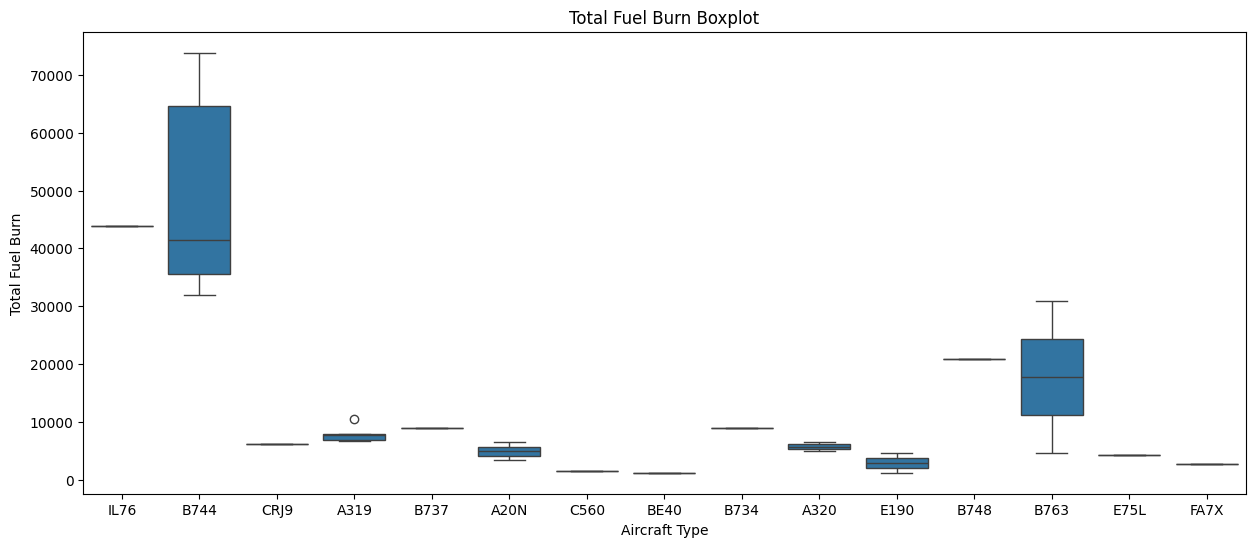

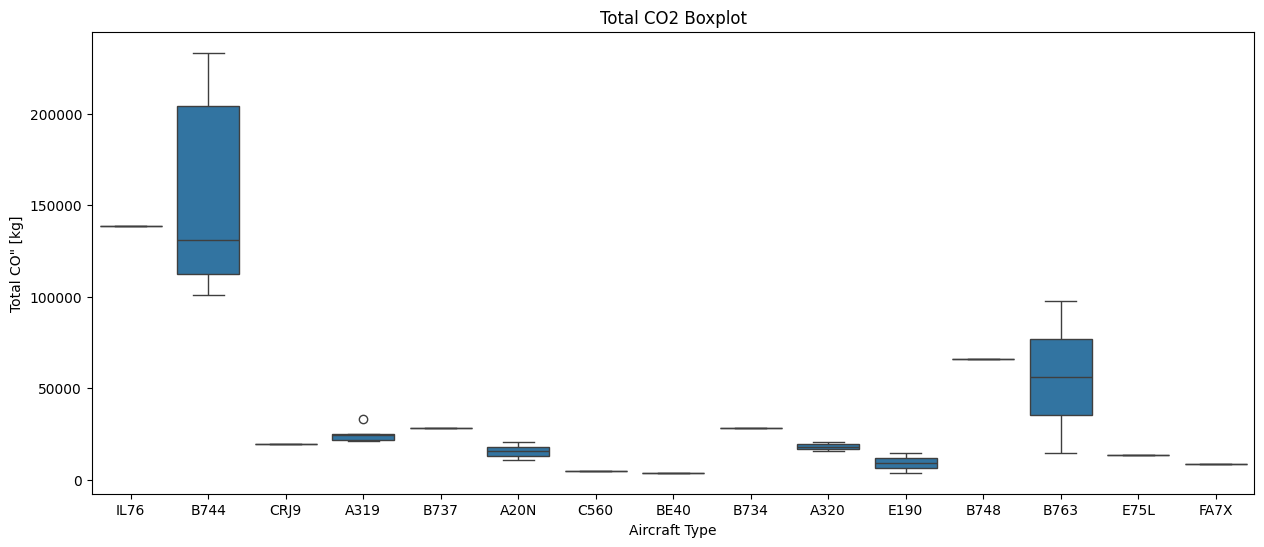

In [43]:
# Boxplot for total_fuel_burn
plt.figure(figsize=(15, 6))
sns.boxplot(x='aircraft_type_icao', y='total_fuel_burn', data=unique_flights_df)
plt.title('Total Fuel Burn Boxplot')
plt.xlabel('Aircraft Type')
plt.ylabel('Total Fuel Burn')
plt.show()

plt.figure(figsize=(15, 6))
sns.boxplot(x='aircraft_type_icao', y='co2_kg', data=unique_flights_df)
plt.title('Total CO2 Boxplot')
plt.xlabel('Aircraft Type')
plt.ylabel('Total CO" [kg]')
plt.show()

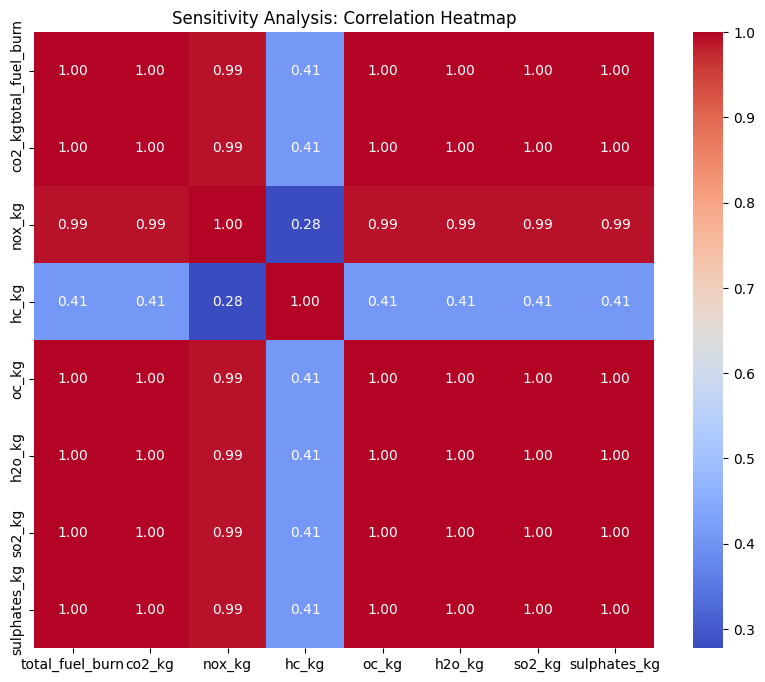

In [44]:
# Sensitivity Analysis
sensitivity_data = unique_flights_df[['total_fuel_burn', 'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg']]

plt.figure(figsize=(10, 8))
sns.heatmap(sensitivity_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Sensitivity Analysis: Correlation Heatmap')
plt.show()

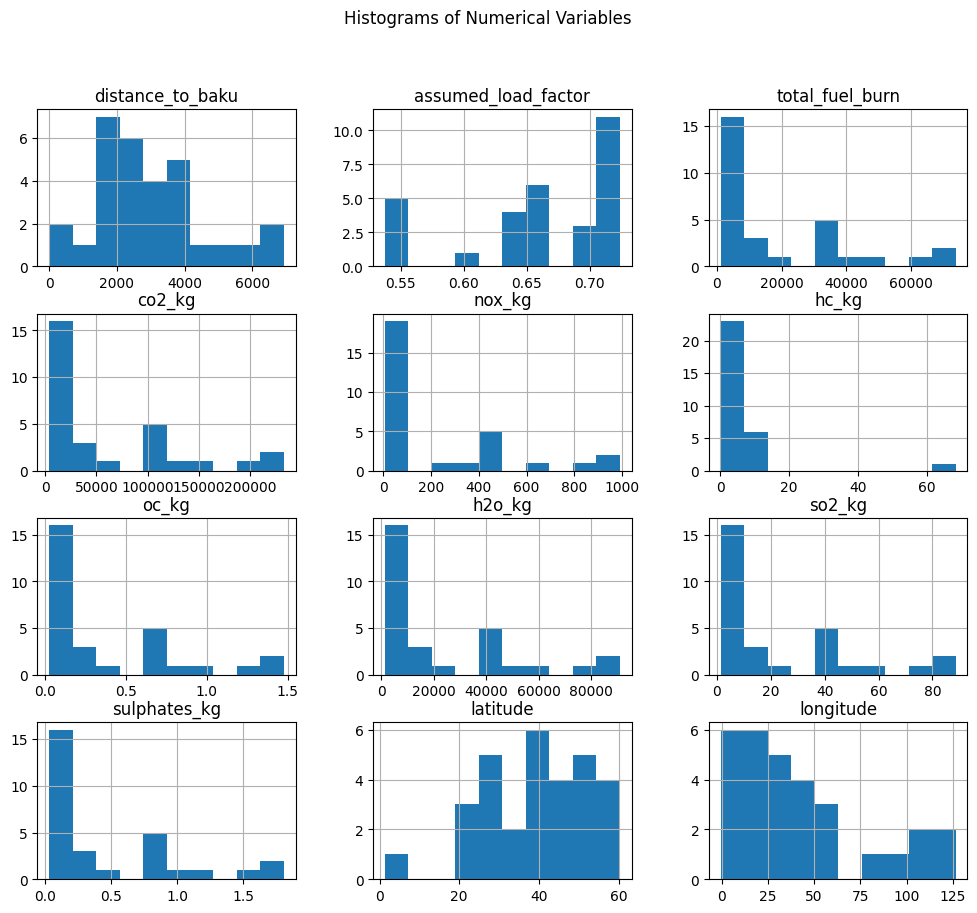

In [45]:
# Histograms
unique_flights_df.hist(figsize=(12, 10))
plt.suptitle('Histograms of Numerical Variables')
plt.show()

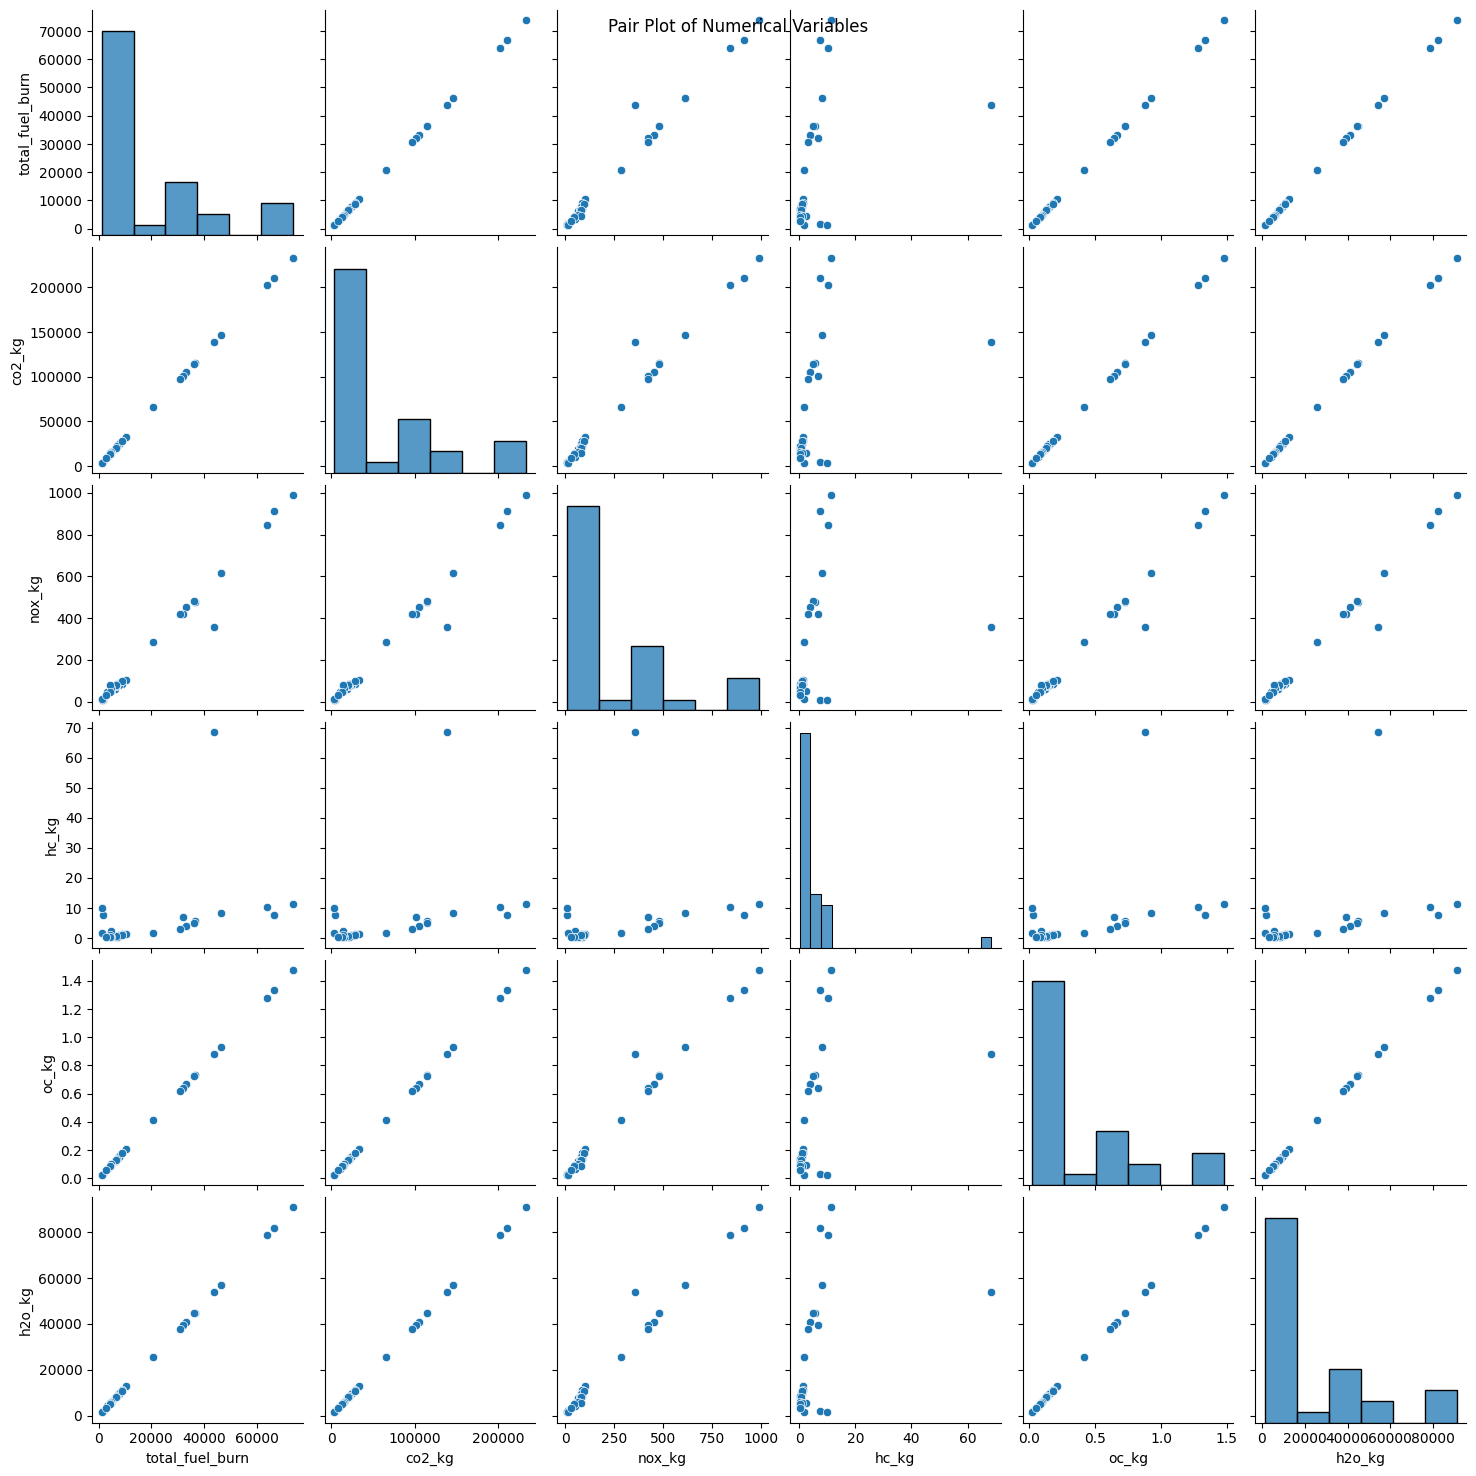

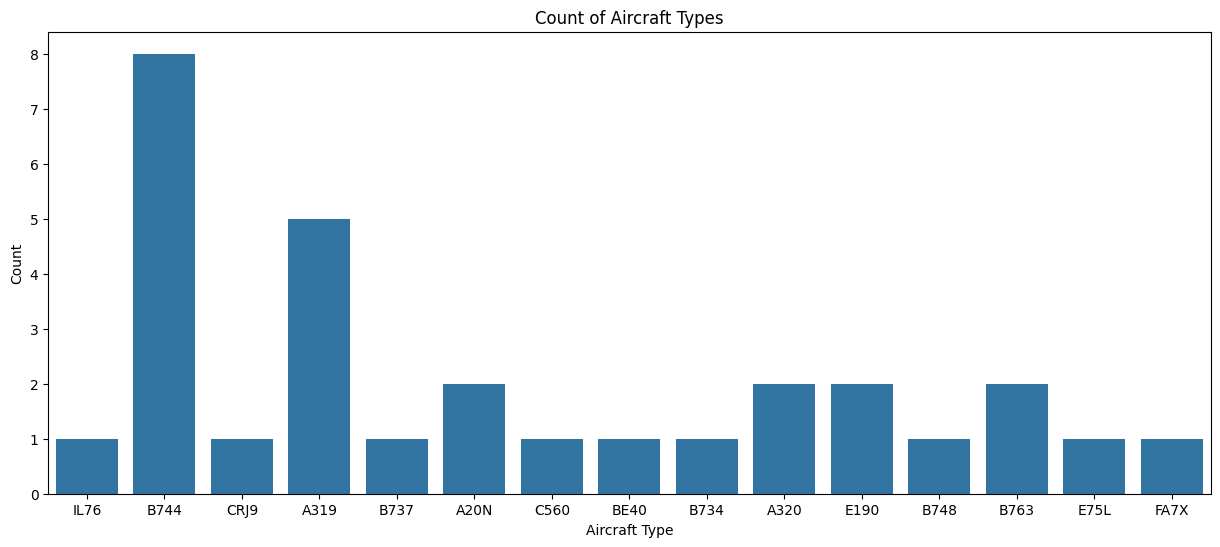

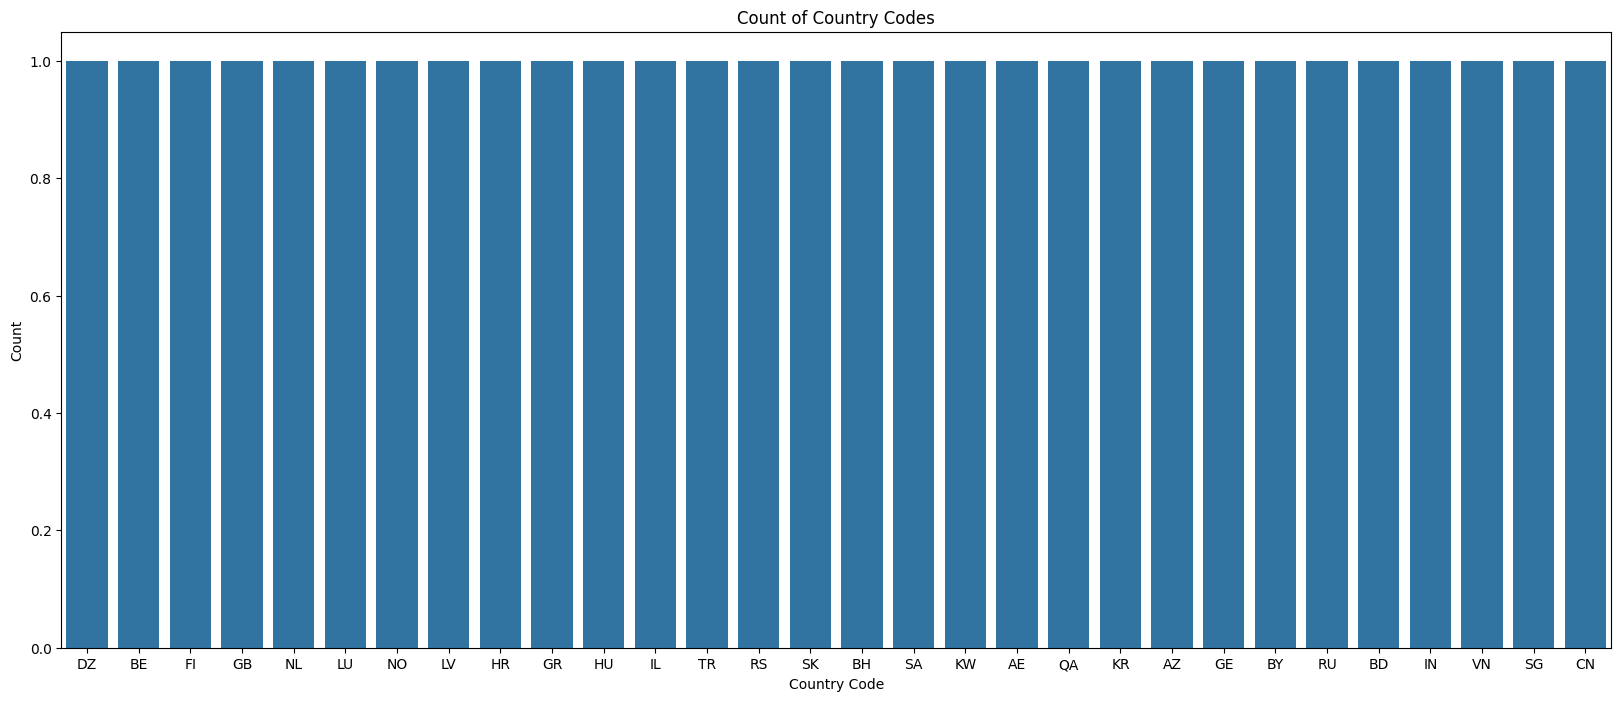

In [46]:
# Scatter Plots
sns.pairplot(unique_flights_df[['total_fuel_burn', 'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg']])
plt.suptitle('Pair Plot of Numerical Variables')
plt.show()

# Bar Plots
plt.figure(figsize=(15, 6))
sns.countplot(x='aircraft_type_icao', data=unique_flights_df)
plt.title('Count of Aircraft Types')
plt.xlabel('Aircraft Type')
plt.ylabel('Count')
plt.show()

# Count Plots
plt.figure(figsize=(20, 8))
sns.countplot(x='country_code', data=unique_flights_df)
plt.title('Count of Country Codes')
plt.xlabel('Country Code')
plt.ylabel('Count')
plt.show()

### 5.2.2 Non-Direct

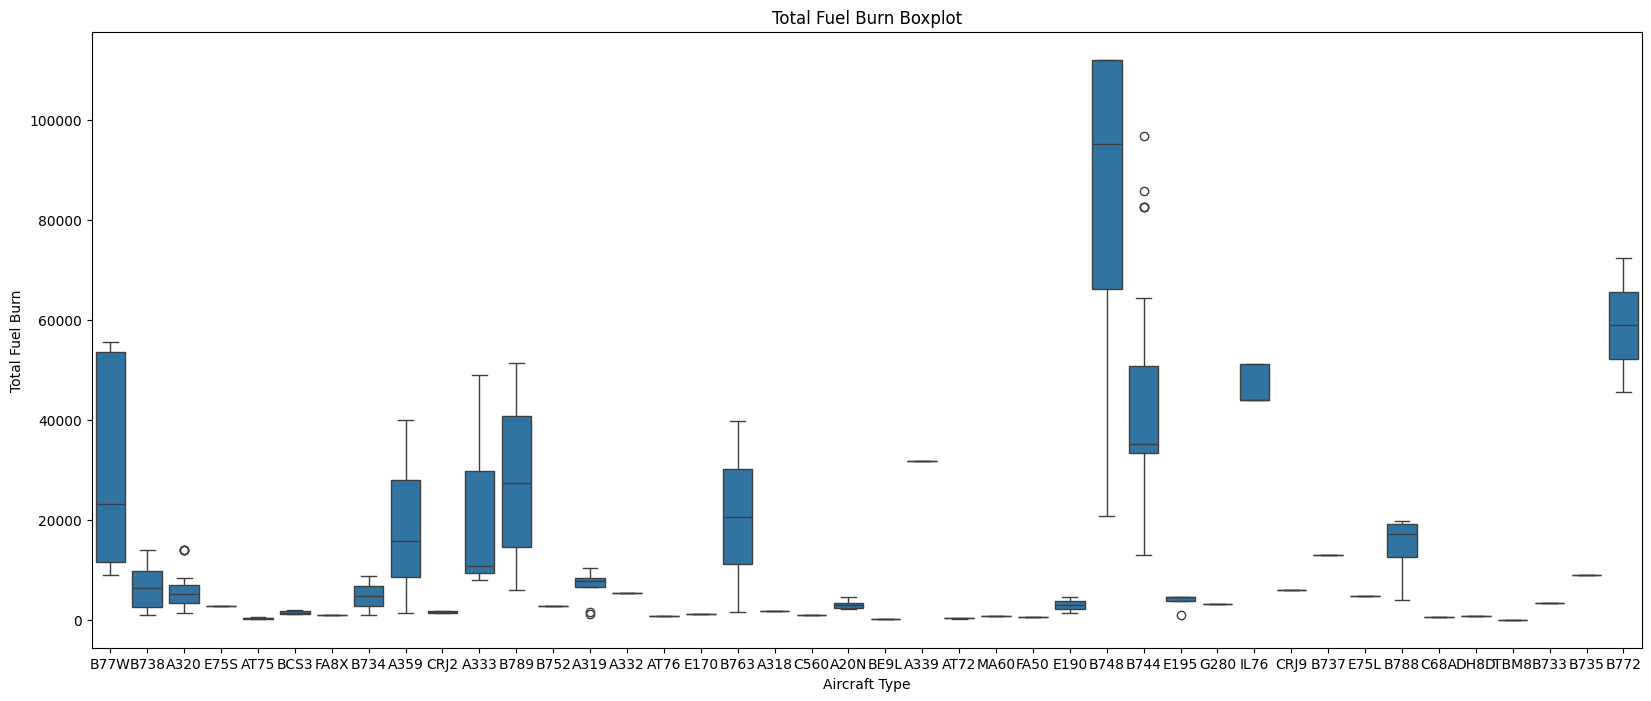

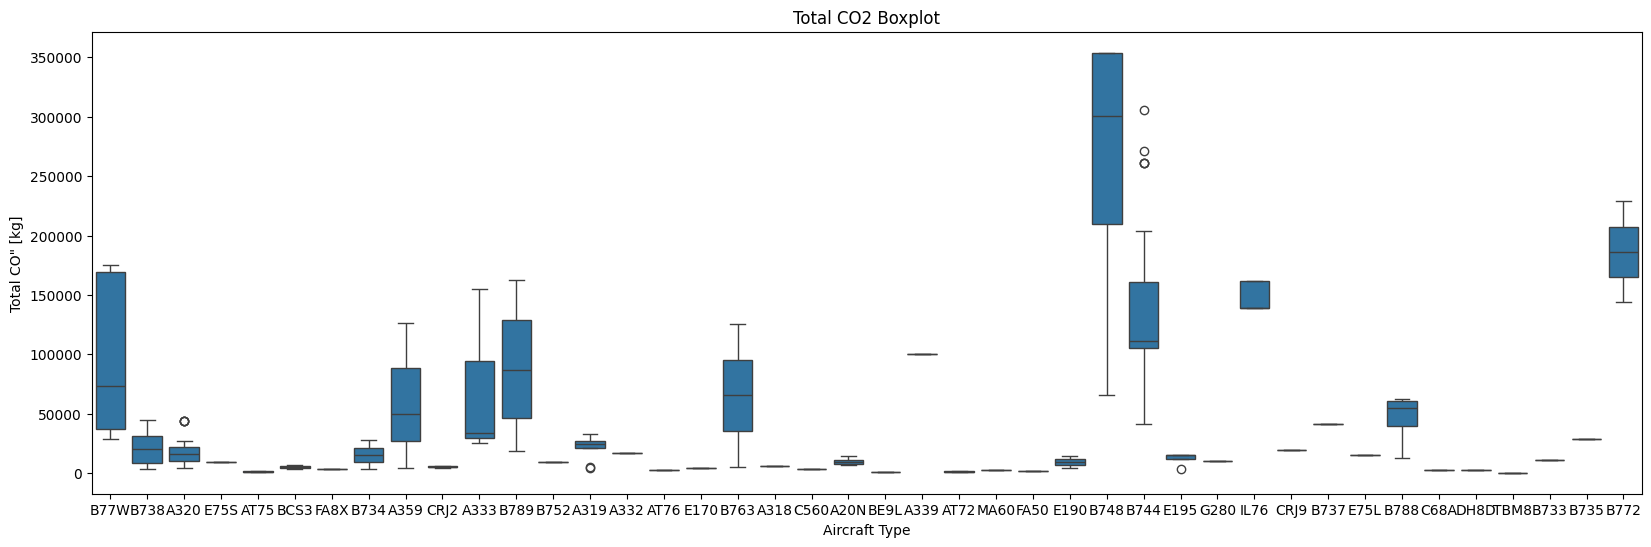

In [47]:
# Boxplot for total_fuel_burn
plt.figure(figsize=(20, 8))
sns.boxplot(x='aircraft_type_icao', y='total_fuel_burn', data=all_flights_non_direct)
plt.title('Total Fuel Burn Boxplot')
plt.xlabel('Aircraft Type')
plt.ylabel('Total Fuel Burn')
plt.show()

plt.figure(figsize=(20, 6))
sns.boxplot(x='aircraft_type_icao', y='co2_kg', data=all_flights_non_direct)
plt.title('Total CO2 Boxplot')
plt.xlabel('Aircraft Type')
plt.ylabel('Total CO" [kg]')
plt.show()


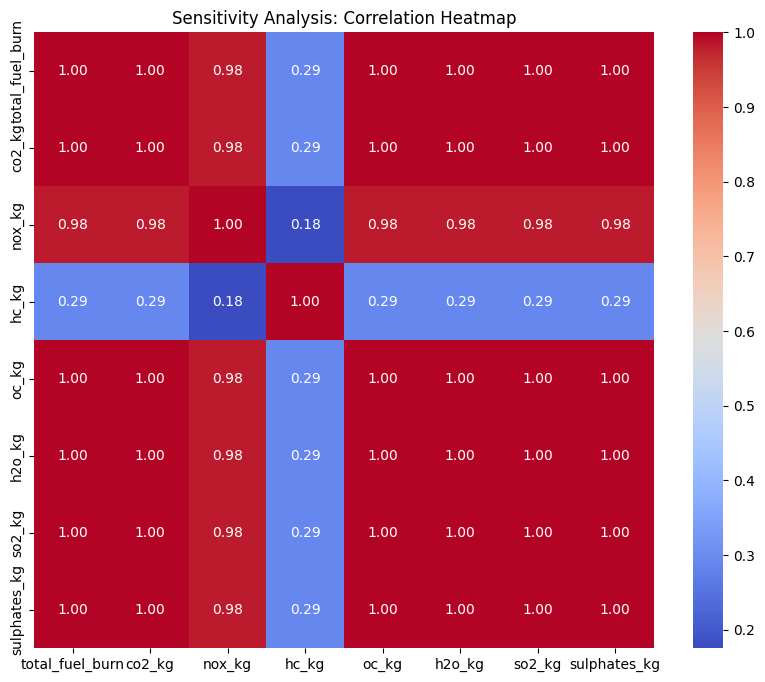

In [50]:
# Sensitivity Analysis
sensitivity_data = all_flights_non_direct[['total_fuel_burn', 'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg']]

plt.figure(figsize=(10, 8))
sns.heatmap(sensitivity_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Sensitivity Analysis: Correlation Heatmap')
plt.show()

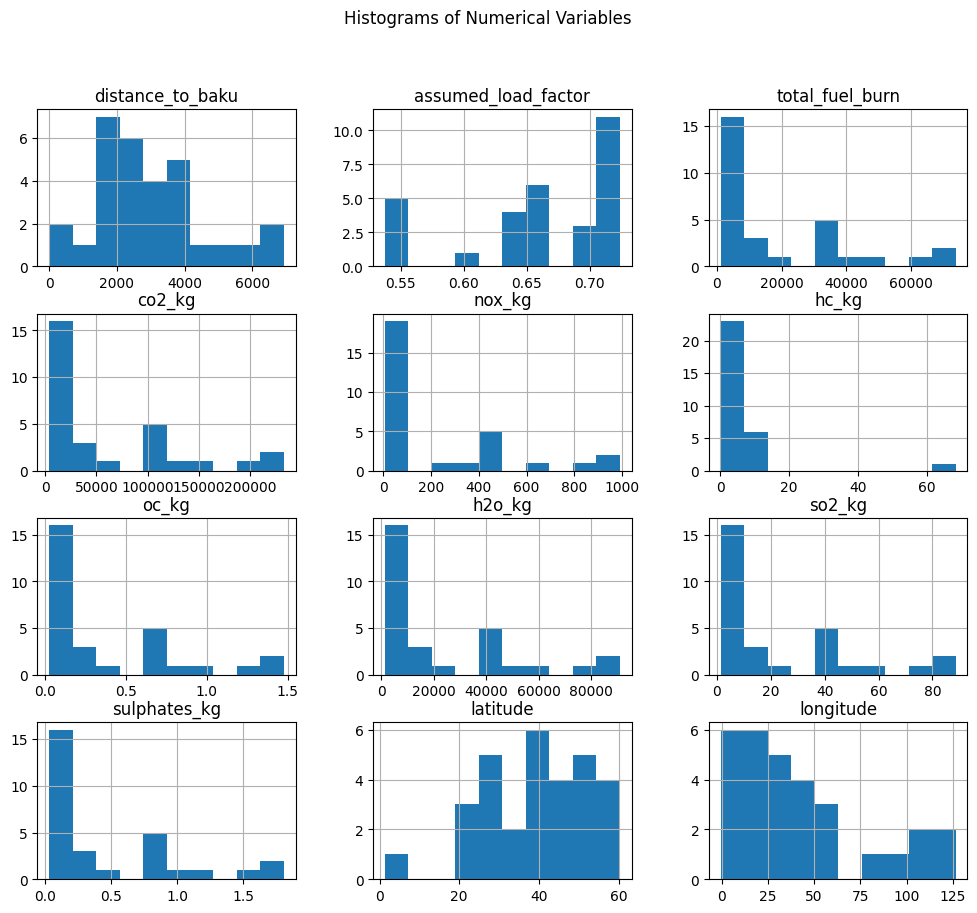

In [52]:
# Histograms
unique_flights_df.hist(figsize=(12, 10))
plt.suptitle('Histograms of Numerical Variables')
plt.show()

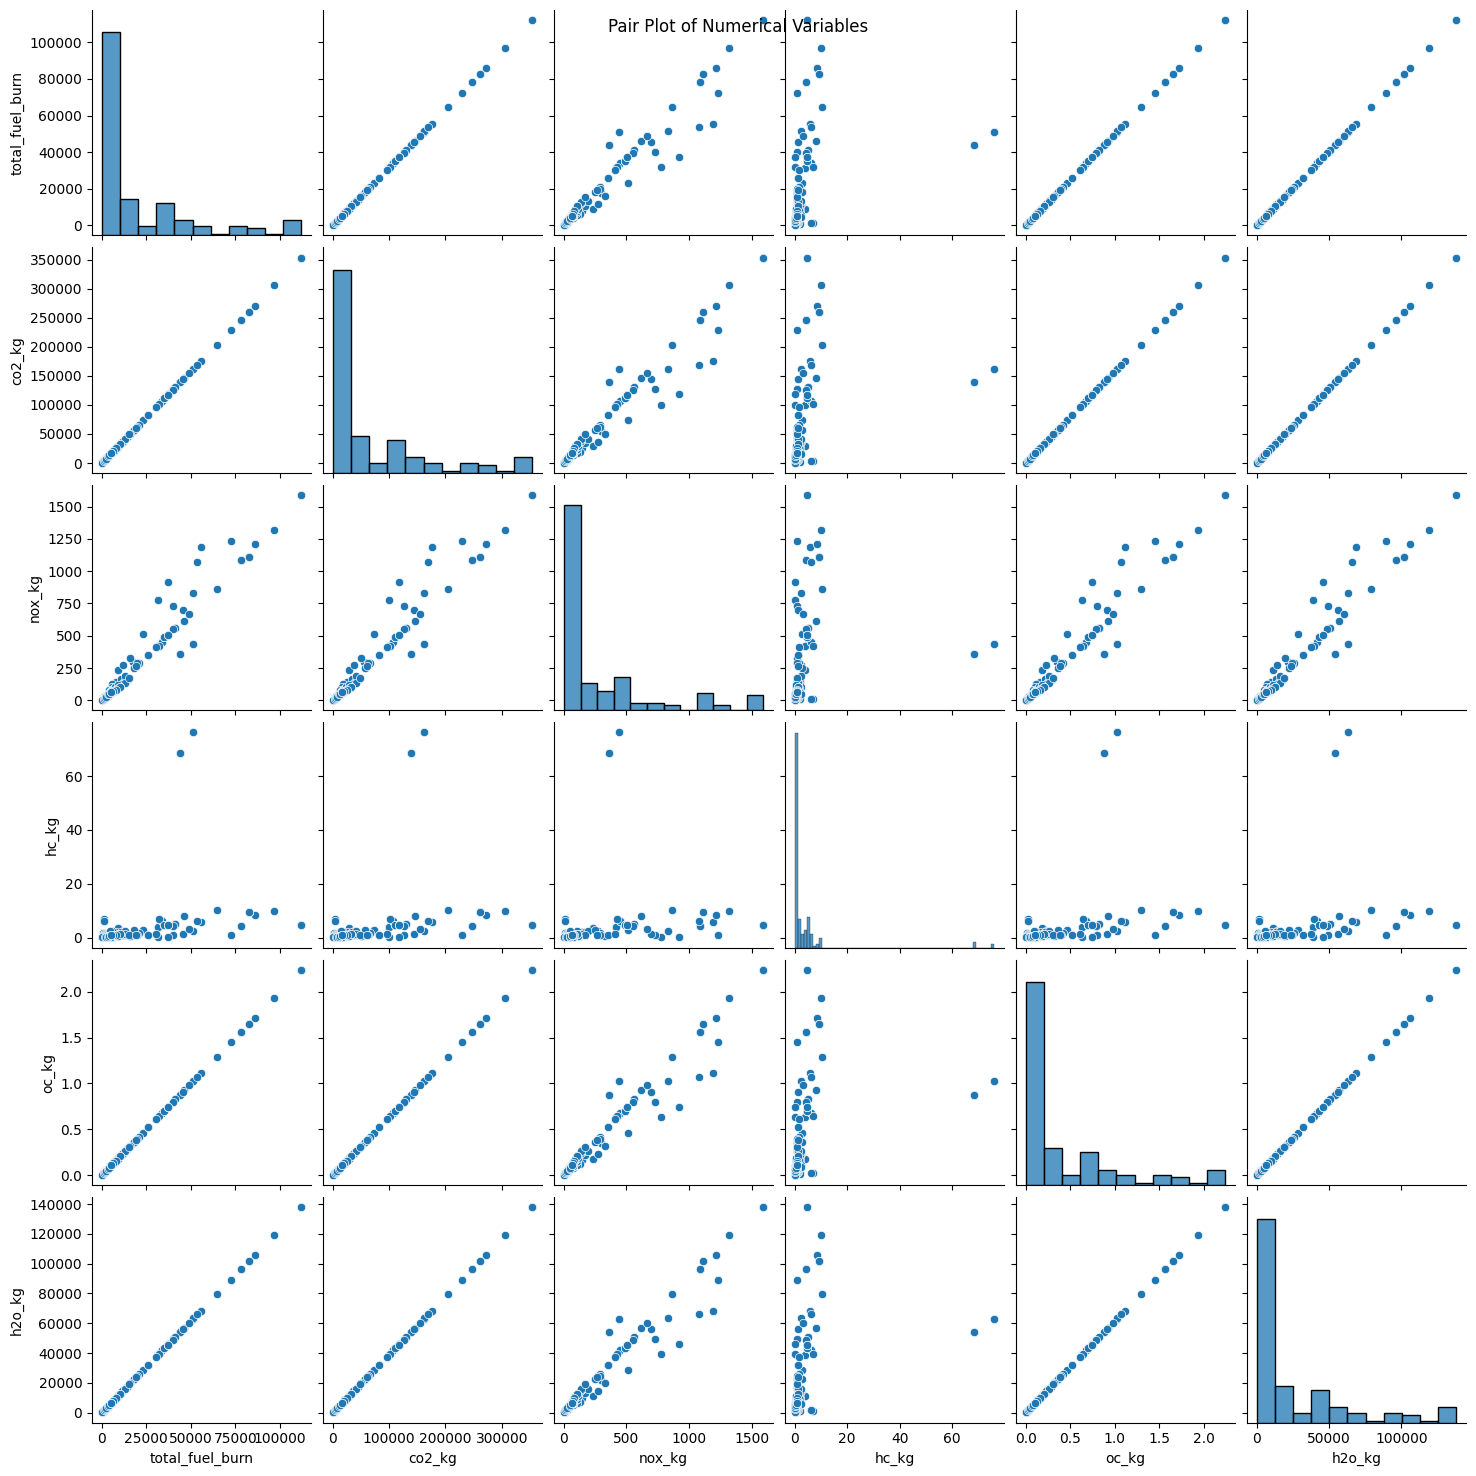

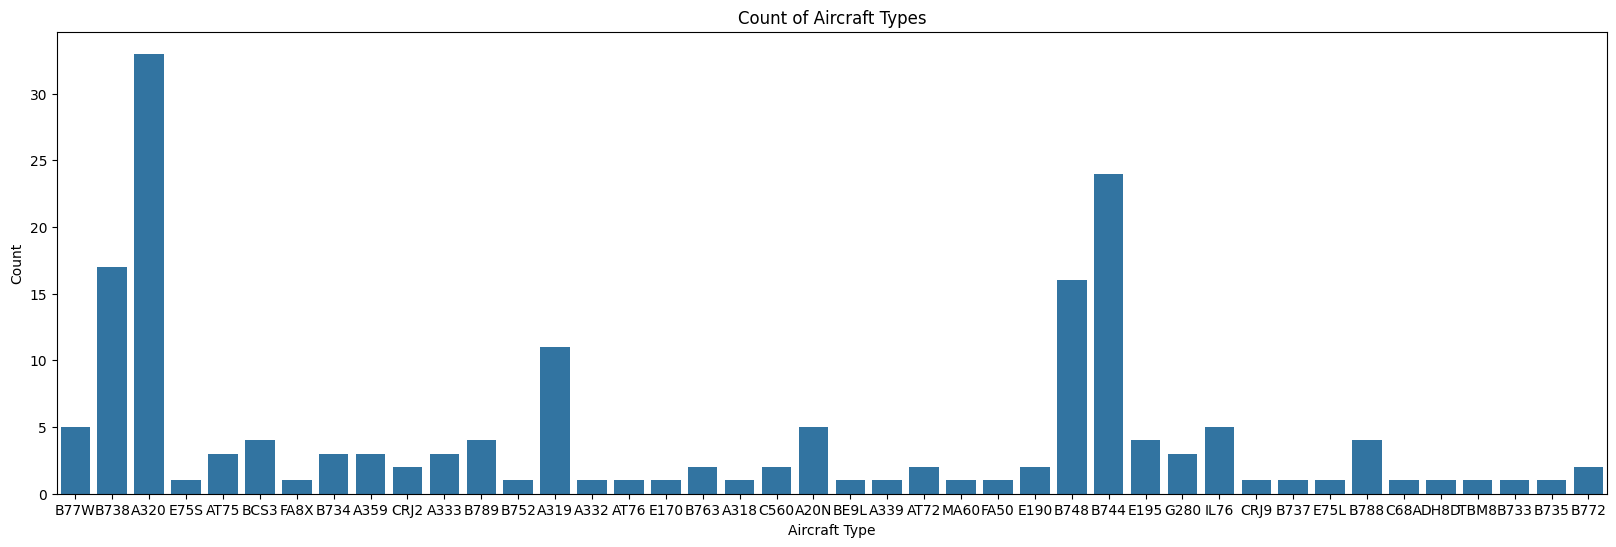

ValueError: Could not interpret value `country_code` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x800 with 0 Axes>

In [49]:
# Scatter Plots
sns.pairplot(all_flights_non_direct[['total_fuel_burn', 'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg']])
plt.suptitle('Pair Plot of Numerical Variables')
plt.show()

# Bar Plots
plt.figure(figsize=(20, 6))
sns.countplot(x='aircraft_type_icao', data=all_flights_non_direct)
plt.title('Count of Aircraft Types')
plt.xlabel('Aircraft Type')
plt.ylabel('Count')
plt.show()

# Count Plots
plt.figure(figsize=(10, 8))
sns.countplot(x='country_code', data=all_flights_non_direct)
plt.title('Count of Country Codes')
plt.xlabel('Country Code')
plt.ylabel('Count')
plt.show()

## Old 
#### First_closest // Single iteration with further split

In [ ]:
merged_df = pd.merge(df_stopover, df, left_on=['icao', 'closest'], right_on=['origin_airport', 'destination_airport'], how='inner')
merged_df = merged_df.drop_duplicates(subset=['icao'], keep='first')
merged_df.reset_index(inplace=True)
merged_df = merged_df.rename(columns={'destination_airport':'hub_airport'})
merged_df = merged_df[['origin_airport','hub_airport',
       'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
       'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_dubai'
       ]]
print(len(merged_df))
merged_df.iloc[:3]

0


,origin_airport,hub_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,to_dubai


##### Hub -> Dubai (First_closest)

In [ ]:
# Remaining flights to be found! 
occurrences_count = merged_df['origin_airport'].value_counts().to_dict()

# Delete the same number of occurrences from df_stopover['icao'] for each value in final_merged_df['origin_airport']
for value, count in occurrences_count.items():
    df_stopover = df_stopover.drop(df_stopover[df_stopover['icao'] == value].head(count).index)

len(df_stopover)

30

In [ ]:
results_closest = merged_df[['hub_airport','to_dubai']]
destination_dubai = pd.merge(results_closest, df, left_on=['hub_airport', 'to_dubai'], right_on=['origin_airport', 'destination_airport'], how='inner')
destination_dubai = destination_dubai.drop_duplicates(subset=['hub_airport'], keep='first')
destination_dubai.reset_index(inplace=True)
# destination_dubai = destination_dubai[['icao','first_closest','origin_airport','destination_airport',
#        'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
#        'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_dubai'
#        ]]
print(len(destination_dubai))
destination_dubai = destination_dubai[['origin_airport','hub_airport',
       'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
       'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg','to_dubai'
       ]]
destination_dubai.iloc[:3]
# destination_dubai['hub_airport'].unique()
# destination_dubai['aircraft_type_icao'].unique()

0


,origin_airport,hub_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,to_dubai


In [ ]:
combined_dfs = []
# Iterate over unique hub_airport values
for hub_airport in merged_df['hub_airport'].unique():
    # Filter the row from destination_dubai
    row = destination_dubai[destination_dubai['origin_airport'] == hub_airport].iloc[0]

    # Number of times to add the row
    num_columns_to_add = (merged_df['hub_airport'] == hub_airport).sum()

    # Create a list of copies of row
    copies_of_row = [row] * num_columns_to_add

    # Concatenate the copies along the columns axis
    combined_df = pd.concat(copies_of_row, axis=1)

    # Transpose the DataFrame to have the rows and columns swapped
    combined_df = combined_df.T

    # Append the combined_df to the list
    combined_dfs.append(combined_df)

all_flights_non_direct = pd.concat([merged_df] + combined_dfs, ignore_index=True)
print(len(all_flights_non_direct))
all_flights_non_direct.iloc[:3]

0


,origin_airport,hub_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,to_dubai


## Heatmap

In [ ]:
scatter_geo = go.Scattergeo(
    locationmode='USA-states',  # Set location mode
    lon=df_stopover['longitude'],
    lat=df_stopover['latitude'],
    # text=df_stopover[''],
    mode='markers',
    marker=dict(
        size=df_stopover['total_delegates']/100,
        # #color=df_stopover['total_delegates']/100,
        # colorscale='Viridis',  # Choose a color scale
        # colorbar=dict(title='Values'),  # Add color bar
        line_width=0.5
    )
)

# Create the layout for the figure
layout = go.Layout(
    title='Global Heatmap with Locations and Size Factor',
    geo=dict(
        scope='world',
        showland=True,
        landcolor='rgb(217, 217, 217)',  # Set the color of land areas
        showframe=False,  # Hide the frame
        projection_type='mercator'  # Choose projection type
    ),
    height=800,  # Increase the height of the plot
)

# Create the figure object
fig = go.Figure(data=[scatter_geo], layout=layout)

# Show the figure
fig.show()

In [ ]:
# Sample data
locations = df_stopover['country_code']
latitudes = df_stopover['latitude']
longitudes = df_stopover['longitude']
sizes = df_stopover['total_delegates']/10
#values = [20, 30, 25, 40]  # Values for the color scale

# Initialize the map centered around the first location
mymap = folium.Map()

# Iterate over locations
for lat, lon, size, location in zip(latitudes, longitudes, sizes, locations):
    # Add circle marker with varying sizes
    folium.CircleMarker(
        location=[lat, lon],
        radius=size / 10,  # Normalize size for better visualization
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=location
    ).add_to(mymap)

# Save the map to an HTML file
mymap.save("origin_participants_remainings.html")

In [ ]:
# basemap = folium.Map()
# FastMarkerCluster(airport_location[['latitude', 'longitude']]).add_to(basemap)
# HeatMap(airport_location[['latitude', 'longitude','total_delegates']],
#         ).add_to(basemap)
# basemap

basemap = folium.Map()
FastMarkerCluster(airport_location[['latitude', 'longitude']]).add_to(basemap)
HeatMap(airport_location[['latitude', 'longitude','total_delegates']],
        max_val=max(airport_location['total_delegates'])).add_to(basemap)
basemap

C:\Users\lukas\AppData\Local\Temp\ipykernel_14380\2891524790.py:9: UserWarning:

The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.

